In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import scipy.io as sio
from scipy.stats import norm
from scipy.stats import multivariate_normal
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.kalman_filter import KalmanFilter
import copy

In [2]:
# Generate synthetic data
# components = ['level','fourrier','ar']
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 1000

AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# Set seed
np.random.seed(0)

data_generator = generate_one_synthetic_time_series(components = components, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters, 
                                                    num_steps = num_steps,
                                                    x_init = x_init)

# # ts = data_generator.generate_time_series()
# data_generator.plot()

In [3]:
# Generate periodic pattern
components_P = ['level','fourrier']

hyperparameters_P = {'level': {'process_error_var': 0.0},
                   'fourrier': {'period': 52, 'process_error_var': 0},
                   'observation': {'error': 0}}
x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
          'var': np.diag([0,1e-12, 1e-12])}

data_generator_P = generate_one_synthetic_time_series(components = components_P, 
                                                    time_step_interval = time_step_interval, 
                                                    hyperparameters = hyperparameters_P, 
                                                    num_steps = num_steps,
                                                    x_init = x_init_P)

# # ts = data_generator.generate_time_series()
# data_generator_P.plot()

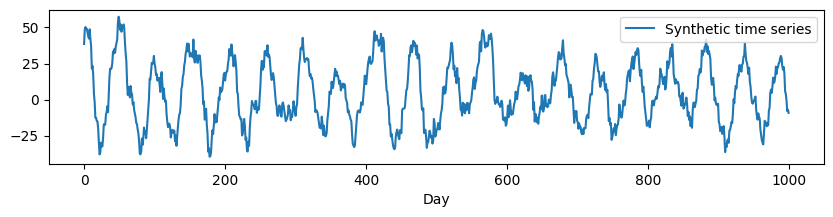

In [4]:
# Add periodic patten
data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

data_generator.plot()

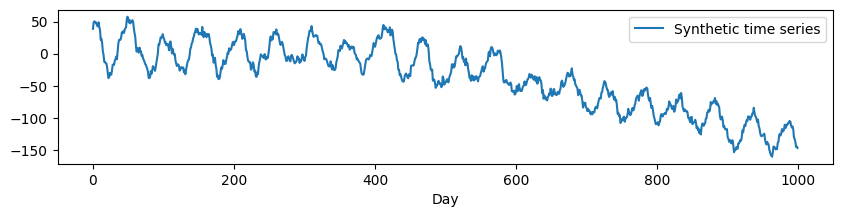

In [5]:
# Add anomaly
anm_pos = 400
anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
LL_anm_mag = -20
for i in range(num_steps):
    # Add anomaly 
    if i >= anm_pos:
        data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
    # if i >= anm_pos:
    #     data_generator.time_series['y'][i] += LL_anm_mag
data_generator.plot()

In [6]:
# # Save data_generator.time_series['y'] to .csv
# observation_file_paths = ['data/observation.csv', 'data/dummy.csv', 'data/dummy2.csv']
# datetime_file_paths = ['data/datetime.csv', 'data/dummy_datetime.csv', 'data/dummy_datetime2.csv']
# start_date = datetime(2000, 1, 1)
# indices_train_val_test = [1000, -1, -1]
# data_generator.time_step_interval = 7
# data_generator.export_to_csv(indices_train_val_test, observation_file_paths, datetime_file_paths, start_date)

In [7]:
from src.RL_functions.base_drift_candidate_model import base_drift_candidate_model
prior_a = [0.998, 0.002]
trigger_pos = []

baseline_process_error_var_all = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# baseline_process_error_var_all = [1e-2]
x_likelihood_na_all = []
x_likelihood_a_all = []
y_likelihood_na_all = []
y_likelihood_a_all = []
for baseline_process_error_var in baseline_process_error_var_all:
    x_likelihood_na, x_likelihood_a, y_likelihood_na, y_likelihood_a = base_drift_candidate_model(baseline_process_error_var, trigger_pos, data_generator, num_steps, AR_param_phi, AR_param_var, time_step_interval)
    x_likelihood_na_all.append(x_likelihood_na)
    x_likelihood_a_all.append(x_likelihood_a)
    y_likelihood_na_all.append(y_likelihood_na)
    y_likelihood_a_all.append(y_likelihood_a)

# Reshape
x_likelihood_na_all = np.array(x_likelihood_na_all).reshape(len(baseline_process_error_var_all), num_steps)
x_likelihood_a_all = np.array(x_likelihood_a_all).reshape(len(baseline_process_error_var_all), num_steps)
y_likelihood_na_all = np.array(y_likelihood_na_all).reshape(len(baseline_process_error_var_all), num_steps)
y_likelihood_a_all = np.array(y_likelihood_a_all).reshape(len(baseline_process_error_var_all), num_steps)

p_a0 = y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] / \
            (y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] + \
             np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
# p_a0 = np.sum(y_likelihood_na_all * x_likelihood_na_all * prior_a[0]/len(baseline_process_error_var_all), axis=0) / \
#             (np.sum(y_likelihood_na_all * x_likelihood_na_all * prior_a[0]/len(baseline_process_error_var_all), axis=0) + \
#              np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
p_na0 = []
for j in range(len(baseline_process_error_var_all)):
    p_aj = y_likelihood_a_all[j] * x_likelihood_a_all[j] * prior_a[1]/len(baseline_process_error_var_all) / \
            (y_likelihood_na_all[0] * np.prod(x_likelihood_na_all, axis=0) * prior_a[0] + \
             np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
    # p_aj = y_likelihood_a_all[j] * x_likelihood_a_all[j] * prior_a[1]/len(baseline_process_error_var_all) / \
    #         (np.sum(y_likelihood_na_all * x_likelihood_na_all * prior_a[0]/len(baseline_process_error_var_all), axis=0) + \
    #          np.sum(y_likelihood_a_all * x_likelihood_a_all * prior_a[1]/len(baseline_process_error_var_all), axis=0))
    p_na0.append(p_aj)
    
p_na0 = np.array(p_na0).reshape(len(baseline_process_error_var_all), num_steps)

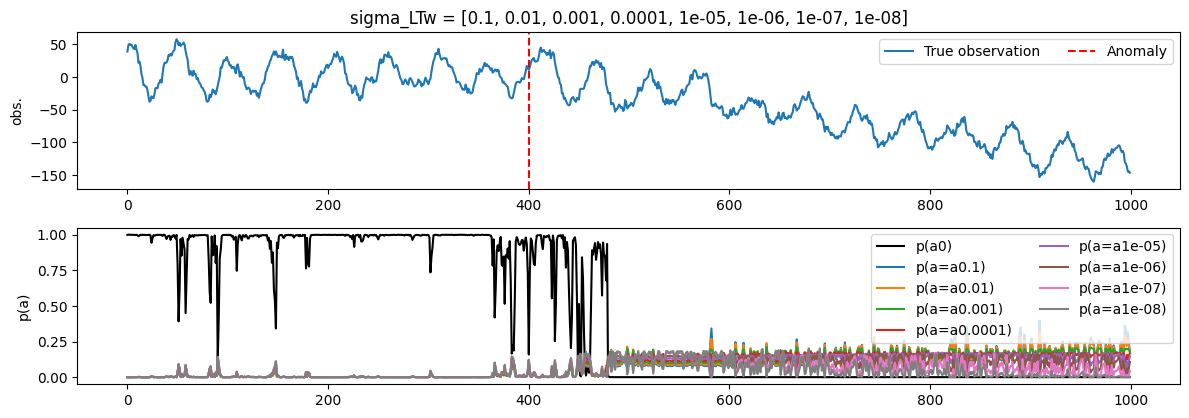

In [25]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
# ax1 = plt.subplot(gs[2])
# ax2 = plt.subplot(gs[3])
# ax3 = plt.subplot(gs[4])
# ax4 = plt.subplot(gs[5])
# ax5 = plt.subplot(gs[6])
# ax6 = plt.subplot(gs[7])
ax1 = plt.subplot(gs[1])
# ax2 = plt.subplot(gs[2])

############ Base model ############
ax0.plot(data_generator.time_series['timesteps'], data_generator.time_series['y'], label='True observation')
if anm_mag != 0:
    ax0.axvline(x=anm_pos, color='r', linestyle='--', label='Anomaly')
ax0.legend(loc='upper right', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all))

ax1.plot(data_generator.time_series['timesteps'], p_a0, 'k', label='p(a0)')
# ax1.plot(data_generator.time_series['timesteps'], 1-p_a0, label='p(a=aj)')
for j in range(len(baseline_process_error_var_all)):
    ax1.plot(data_generator.time_series['timesteps'], p_na0[j], label='p(a=a' + str(baseline_process_error_var_all[j]) + ')')
ax1.set_ylabel('p(a)')
# ax1.set_ylim([0, 0.2])
ax1.legend(loc='upper right', ncol = 2)

# for j in range(len(baseline_process_error_var_all)):
#     ax2.plot(data_generator.time_series['timesteps'], p_na0[j], label='p(a=a' + str(baseline_process_error_var_all[j]) + ')')
# ax2.set_ylabel('p(a=aj)')
# ax2.legend(loc='upper left', ncol = 2)

# ax2.plot(data_generator.time_series['timesteps'], y_likelihood_a_all[0], label='action')
# ax2.plot(data_generator.time_series['timesteps'], y_likelihood_na_all[0], label='no action')
# ax2.set_ylabel('L_y')
# ax2.set_title('sigma_LTw = ' + str(baseline_process_error_var_all[0]))
# ax2.legend(loc='upper left', ncol = 2)

# ax3.plot(data_generator.time_series['timesteps'], x_likelihood_a_all[0], label='action')
# ax3.plot(data_generator.time_series['timesteps'], x_likelihood_na_all[0], label='no action')
# ax3.set_ylabel('L_x')
# ax3.legend(loc='upper left', ncol = 2)

In [23]:
print('probabilities of 8 models (aj):')
print(p_na0[:,90])
print('probabilities of a0:')
print(p_a0[90])

print(np.sum(p_na0[:,90])+p_a0[90])


probabilities of 8 models (aj):
[0.06079064 0.06869618 0.08125622 0.11261374 0.13777315 0.14226949
 0.14234712 0.14236935]
probabilities of a0:
0.11188411366701867
1.0
